
# Partial Dependence and Individual Conditional Expectation Plots

Partial dependence plots show the dependence between the target function [2]_
and a set of features of interest, marginalizing over the values of all other
features (the complement features). Due to the limits of human perception, the
size of the set of features of interest must be small (usually, one or two)
thus they are usually chosen among the most important features.

Similarly, an individual conditional expectation (ICE) plot [3]_
shows the dependence between the target function and a feature of interest.
However, unlike partial dependence plots, which show the average effect of the
features of interest, ICE plots visualize the dependence of the prediction on a
feature for each :term:`sample` separately, with one line per sample.
Only one feature of interest is supported for ICE plots.

This example shows how to obtain partial dependence and ICE plots from a
:class:`~sklearn.neural_network.MLPRegressor` and a
:class:`~sklearn.ensemble.HistGradientBoostingRegressor` trained on the
California housing dataset. The example is taken from [1]_.

.. [1] T. Hastie, R. Tibshirani and J. Friedman, "Elements of Statistical
       Learning Ed. 2", Springer, 2009.

.. [2] For classification you can think of it as the regression score before
       the link function.

.. [3] Goldstein, A., Kapelner, A., Bleich, J., and Pitkin, E., Peeking Inside
       the Black Box: Visualizing Statistical Learning With Plots of
       Individual Conditional Expectation. (2015) Journal of Computational and
       Graphical Statistics, 24(1): 44-65 (https://arxiv.org/abs/1309.6392)


In [12]:
import sklearn
sklearn.set_config(display="diagram")

## California Housing data preprocessing

Center target to avoid gradient boosting init bias: gradient boosting
with the 'recursion' method does not account for the initial estimator
(here the average target, by default).



In [1]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## 1-way partial dependence with different models

In this section, we will compute 1-way partial dependence with two different
machine-learning models: (i) a multi-layer perceptron and (ii) a
gradient-boosting. With these two models, we illustrate how to compute and
interpret both partial dependence plot (PDP) and individual conditional
expectation (ICE).

### Multi-layer perceptron

Let's fit a :class:`~sklearn.neural_network.MLPRegressor` and compute
single-variable partial dependence plots.



In [2]:
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

print("Training MLPRegressor...")
tic = time()
est = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(
        hidden_layer_sizes=(50, 50), learning_rate_init=0.01, early_stopping=True
    ),
)
est.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 6.018s
Test R2 score: 0.83


We configured a pipeline to scale the numerical input features and tuned the
neural network size and learning rate to get a reasonable compromise between
training time and predictive performance on a test set.

Importantly, this tabular dataset has very different dynamic ranges for its
features. Neural networks tend to be very sensitive to features with varying
scales and forgetting to preprocess the numeric feature would lead to a very
poor model.

It would be possible to get even higher predictive performance with a larger
neural network but the training would also be significantly more expensive.

Note that it is important to check that the model is accurate enough on a
test set before plotting the partial dependence since there would be little
use in explaining the impact of a given feature on the prediction function of
a poor model.

We will plot the partial dependence, both individual (ICE) and averaged one
(PDP). We limit to only 50 ICE curves to not overcrowd the plot.



Computing partial dependence plots...
done in 1.841s


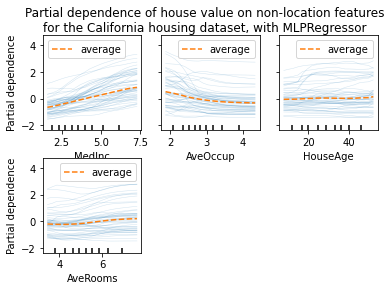

In [3]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

print("Computing partial dependence plots...")
tic = time()
features = ["MedInc", "AveOccup", "HouseAge", "AveRooms"]
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with MLPRegressor"
)
display.figure_.subplots_adjust(hspace=0.3)

### Gradient boosting

Let's now fit a :class:`~sklearn.ensemble.HistGradientBoostingRegressor` and
compute the partial dependence on the same features.



In [4]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
est = HistGradientBoostingRegressor()
est.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 1.305s
Test R2 score: 0.85


Here, we used the default hyperparameters for the gradient boosting model
without any preprocessing as tree-based models are naturally robust to
monotonic transformations of numerical features.

Note that on this tabular dataset, Gradient Boosting Machines are both
significantly faster to train and more accurate than neural networks. It is
also significantly cheaper to tune their hyperparameters (the defaults tend
to work well while this is not often the case for neural networks).

We will plot the partial dependence, both individual (ICE) and averaged one
(PDP). We limit to only 50 ICE curves to not overcrowd the plot.



Computing partial dependence plots...
done in 2.391s


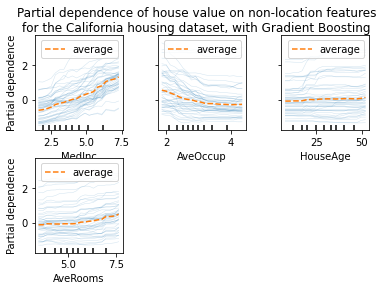

In [5]:
print("Computing partial dependence plots...")
tic = time()
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with Gradient Boosting"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

### Analysis of the plots

We can clearly see on the PDPs (thick blue line) that the median house price
shows a linear relationship with the median income (top left) and that the
house price drops when the average occupants per household increases (top
middle). The top right plot shows that the house age in a district does not
have a strong influence on the (median) house price; so does the average
rooms per household.

The ICE curves (light blue lines) complement the analysis: we can see that
there are some exceptions, where the house price remain constant with median
income and average occupants. On the other hand, while the house age (top
right) does not have a strong influence on the median house price on average,
there seems to be a number of exceptions where the house price increase when
between the ages 15-25. Similar exceptions can be observed for the average
number of rooms (bottom left). Therefore, ICE plots show some individual
effect which are attenuated by taking the averages.

In all plots, the tick marks on the x-axis represent the deciles of the
feature values in the training data.

We also observe that :class:`~sklearn.neural_network.MLPRegressor` has much
smoother predictions than
:class:`~sklearn.ensemble.HistGradientBoostingRegressor`.

However, it is worth noting that we are creating potential meaningless
synthetic samples if features are correlated.



## 2D interaction plots

PDPs with two features of interest enable us to visualize interactions among
them. However, ICEs cannot be plotted in an easy manner and thus interpreted.
Another consideration is linked to the performance to compute the PDPs. With
the tree-based algorithm, when only PDPs are requested, they can be computed
on an efficient way using the `'recursion'` method.



Computing partial dependence plots...
done in 0.343s


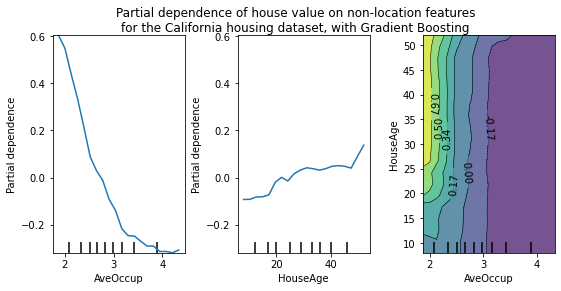

In [6]:
features = ["AveOccup", "HouseAge", ("AveOccup", "HouseAge")]
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with Gradient Boosting"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Plot the values reported by `feature_importances_`. Is there anything looking strange?
</div>

In [7]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [8]:
categorical_columns = ['pclass', 'sex', 'embarked']
numerical_columns = ['age', 'sibsp', 'parch', 'fare']

X = X[categorical_columns + numerical_columns]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])
preprocessing

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['pclass', 'sex', 'embarked']),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['age', 'sibsp', 'parch', 'fare'])])

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Computing partial dependence plots...


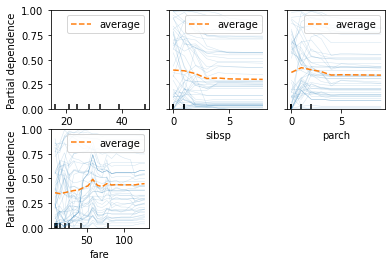

In [18]:
print("Computing partial dependence plots...")
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    numerical_columns,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)